In [16]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.circuit.library import ZZFeatureMap
%matplotlib inline

# Variational Quantum Classifier

This will be a Variational Quantum Classifier based on the paper
https://arxiv.org/pdf/2010.07335.pdf

In this paper, they break up the process of quantum classification into 3 stages:
1. State Preparation - Essentially Rotating Data into the correct format
2. Model Circuit - Runs the model through trainable and non-trainable gates
3. Measurement and Postprocessing - Does measurement and recalculates weights on a classical computer

## State Preparation

State preparation involves encoding data using the RYGate so that we can prep the data for input

In [2]:
def Sx(x):
    circ = QuantumCircuit(len(x), 1)
    for i in range(len(x)):
        circ.ry(2*x[i], i)
    return circ

## Model Circuit

The model circuit stacks multiply layers of trainable parameters together for classification

In [3]:
# alphas, betas, gammas are matrices with N rows and l cols where
# N is the number of qubits and l is the number of layers
def _U(alphas, betas, gammas):
    if alphas.shape != betas.shape or betas.shape != gammas.shape:
        raise Exception("Input parameters do not have match shapes")
    if len(alphas) <= 1:
        raise Exception("Must have at least two qubits")
    circ = QuantumCircuit(len(alphas), 1)
    # Assume non jagged arrays, we want to iterate on number of layers then
    # number of qubits
    for i in range(len(alphas[0])):
        for j in range(len(alphas)):
            circ.rz(gammas[j,i], j)
            circ.ry(betas[j,i], j)
            circ.rz(alphas[j,i], j)
        # Currently unsure how to support more than 2 qubits for this part
        # For now, assuming exactly two qubits
        circ.cx(0, 1)
        circ.cx(1, 0)
    return circ

def U(w):
    if len(w) != 3:
        raise Exception("Theta must be a 3d array with the outermost dimension being 3")
    return _U(w[0], w[1], w[2])

## Measurement and Postprocessing

Here we create a basic circuit to measure the circuit to get the output and 

In [4]:
# Doing this as a separate function because we may want to generalize for
# a multi-class classifier later
# N is the number of qubits
def measurement(N):
    circ = QuantumCircuit(N, 1)
    circ.z(0) # I am pretty sure this is required
    circ.measure([0], [0])
    return circ

In [5]:
def pi(w, x, shots=2048, feature_map=None):
    # Create the simulator backend
    backend = Aer.get_backend("qasm_simulator")
    # Build the circuit
    sx   = Sx(x)
    u    = U(w)
    meas = measurement(N)
    circ = sx + u + meas
    # Execute the job
    job = execute(circ, backend, shots=shots)
    res = job.result()
    counts = res.get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    return counts['0']/shots - counts['1']/shots, counts

def f(w, bias, x, shots=2048, feature_map=None):
    return pi(w, x, shots=shots, feature_map=feature_map)[0] + bias

def classify(w, bias, x, shots=2048, feature_map=None):
    return 1 if f(w, bias, x, shots=shots, feature_map=feature_map) > 0 else -1

## Putting it all together

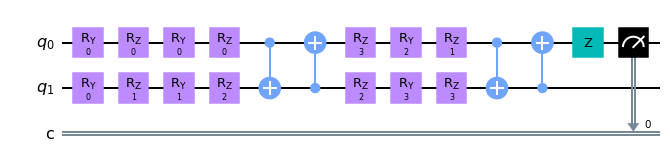

In [6]:
# Testing to make sure the circuit builds properly
N = 2
x = np.array([0, 0])
alphas = np.array([[0, 1], [2, 3]])
betas  = np.array([[0, 2], [1, 3]])
gammas = np.array([[0, 3], [1, 2]])
w = np.array([alphas, betas, gammas])
sx   = Sx(x)
u    = U(w)
meas = measurement(N)

circ = sx + u + meas
circ.draw("mpl")

In [7]:
# Testing to see if I get valid output from classify
expectationVal, counts = pi(w, x)

Expectation Value: -0.5166015625


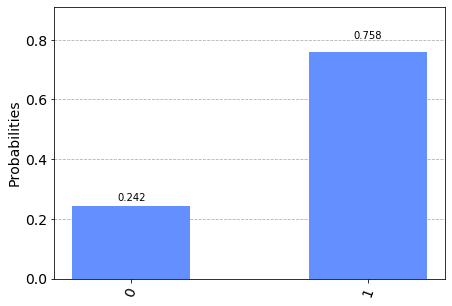

In [8]:
print("Expectation Value: {}".format(expectationVal))
plot_histogram(counts)

## Optimization and Training

$\text{MSE} = (1/n)\sum_{i = 1}^{n}(\hat{y} - f(w, b, x_i))^2$

$\frac{\delta}{\delta w_i} \text{MSE} = (1/n)\sum_{i=1}^n 2(\hat{y} - f(w, b, x_i))(-\frac{\delta}{\delta w_i}f)$

In [21]:
def MSELoss(yhats, ys, shots=2048, feature_map=None):
    if len(yhats) != len(ys):
        raise Exception("Length of yhats must match length of ys")
    return np.sum((yhats - ys)**2)/len(xs)

def gradF(w, maskW, bias, maskB, x, shots=2048, r=0.5, feature_map=None):
    return r*(f(w+maskW, bias+maskB, x, shots) - f(w-maskW, bias-maskB, x, shots))

def gradMSE_w(w, bias, xs, yhats, ys, shots=2048, r=0.5, feature_map=None):
    s = np.pi/(4*r)
    grad = np.zeros_like(w)
    mask = np.zeros_like(w)
    for i in range(len(w)):
        for j in range(len(w[i])):
            for k in range(len(w[i][j])):
                mask[i][j][k] = s
                func = lambda ind: 2*(yhats[ind] - ys[ind])*gradF(w, mask, bias, 0, xs[ind], shots=shots, r=r)
                grad[i][j][k] = np.sum(np.vectorize(func)(np.arange(len(xs))))
                mask[i][j][k] = 0
    return grad/len(xs)

def gradMSE_b(w, bias, xs, yhats, ys, shots=2048, r=0.5, feature_map=None):
    s = np.pi/(4*r)
    mask = np.zeros_like(w)
    func = lambda ind: 2*(yhats[ind] - ys[ind])*gradF(w, mask, bias, s, xs[ind], shots, r)
    return np.sum(np.vectorize(func)(np.arange(0, len(xs), 1)))

def train(xs, ys, qubits=2, layers=2, numEpochs=100, eta=1e-3, shots=2048):
    w = np.random.rand(3, qubits, layers)
    b = np.random.rand()

    for epoch in range(numEpochs):
        func = lambda x: f(w, b, x, shots)
        yhats = np.apply_along_axis(func, 1, xs)
        if epoch % 5 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, MSELoss(yhats, ys, shots)))
        gradW = gradMSE_w(w, b, xs, yhats, ys, shots)
        gradB = gradMSE_b(w, b, xs, yhats, ys, shots)
        w = w - eta*gradW
        b = b - eta*gradB
    return w, b

## Ad Hoc Dataset

Note this is difficult to train

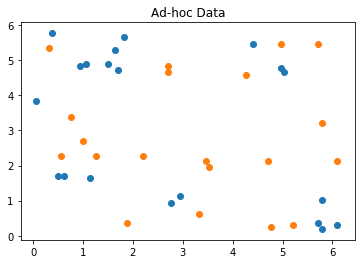

{'A': 0, 'B': 1}


In [19]:
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20,
    test_size=10,
    n=feature_dim,
    gap=0.3,
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

In [ ]:
xs = datapoints[0]
ys = datapoints[1]
ys[ys == 0] = -1
order = np.arange(len(xs))
np.random.shuffle(order)
xs = xs[order]
ys = ys[order]

In [ ]:
train(xs, ys)

## Breast Cancer Dataset

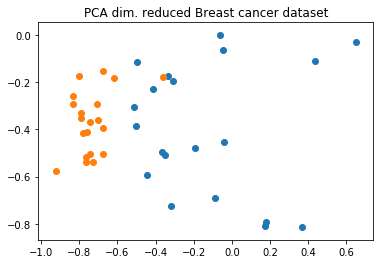

In [10]:
from qiskit.ml.datasets import breast_cancer

feature_dim = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=feature_dim,
    plot_data=True
)
datapoints, class_to_label = split_dataset_to_data_and_labels(training_input)

In [11]:
xs = datapoints[0]
ys = datapoints[1]
ys[ys == 0] = -1
order = np.arange(len(xs))
np.random.shuffle(order)
xs = xs[order]
ys = ys[order]

In [12]:
# Base training attempt
W, b = train(xs, ys, qubits=2, layers=2, numEpochs=100, eta=1e-3, shots=2048) # 2 qubits, 2 layers

Epoch: 0, Loss: 1.0840114557102931
Epoch: 5, Loss: 0.9400360849340176
Epoch: 10, Loss: 0.9011907424562278
Epoch: 15, Loss: 0.877472399196726
Epoch: 20, Loss: 0.8602993671434754
Epoch: 25, Loss: 0.8731182434005488
Epoch: 30, Loss: 0.853130467135254
Epoch: 35, Loss: 0.8503650038804483
Epoch: 40, Loss: 0.8509576339421203
Epoch: 45, Loss: 0.8400938005775451
Epoch: 50, Loss: 0.8220503540541808
Epoch: 55, Loss: 0.8262180990692041
Epoch: 60, Loss: 0.8102504960246362
Epoch: 65, Loss: 0.8082677637275821
Epoch: 70, Loss: 0.8013821794470403
Epoch: 75, Loss: 0.7995241785836888
Epoch: 80, Loss: 0.7980487714485776
Epoch: 85, Loss: 0.7891765798890169
Epoch: 90, Loss: 0.7793543264746992
Epoch: 95, Loss: 0.7826813900378319


In [18]:
# Reduce eta to 1e-2
W, b = train(xs, ys, qubits=2, layers=2, numEpochs=100, eta=1e-2, shots=2048)

Epoch: 0, Loss: 1.5793054706440002
Epoch: 5, Loss: 1.0483906538095753
Epoch: 10, Loss: 0.9941267809955082
Epoch: 15, Loss: 0.9355451720151498
Epoch: 20, Loss: 0.8897459872522809
Epoch: 25, Loss: 0.8387201732402596
Epoch: 30, Loss: 0.8063706843757815
Epoch: 35, Loss: 0.7627423128765025
Epoch: 40, Loss: 0.7195525558131977
Epoch: 45, Loss: 0.6890735760096411
Epoch: 50, Loss: 0.6638901808825359
Epoch: 55, Loss: 0.6351132887730341
Epoch: 60, Loss: 0.6139602749463053
Epoch: 65, Loss: 0.5949579289260297
Epoch: 70, Loss: 0.5770896530552921
Epoch: 75, Loss: 0.565160533404209
Epoch: 80, Loss: 0.5374115019690586
Epoch: 85, Loss: 0.5325542541886635
Epoch: 90, Loss: 0.5169122893693288
Epoch: 95, Loss: 0.5025843447658129


(array([[[0.26695133, 0.72262299],
         [0.77228976, 0.7845504 ]],
 
        [[0.76301881, 0.33153795],
         [0.37389904, 1.07733721]],
 
        [[0.18519765, 0.32416806],
         [0.58381307, 0.19958474]]]), -0.3351626506667767)

In [23]:
# Keep eta reduced and reduce the number of layers to 1
W, b = train(xs, ys, qubits=2, layers=1, numEpochs=100, eta=1e-2, shots=2048)

Epoch: 0, Loss: 2.167476489923228
Epoch: 5, Loss: 0.9375120878785873
Epoch: 10, Loss: 0.9372474540359509
Epoch: 15, Loss: 0.9405042663858527
Epoch: 20, Loss: 0.9335762730372743
Epoch: 25, Loss: 0.9364246364298768
Epoch: 30, Loss: 0.9436438140659306
Epoch: 35, Loss: 0.9408112306060523
Epoch: 40, Loss: 0.9347221661727761
Epoch: 45, Loss: 0.9340141876631499
Epoch: 50, Loss: 0.9381981835065657
Epoch: 55, Loss: 0.9408746879144303
Epoch: 60, Loss: 0.9342696059439186
Epoch: 65, Loss: 0.9301816940280572
Epoch: 70, Loss: 0.924794267200822
Epoch: 75, Loss: 0.93401968996308
Epoch: 80, Loss: 0.9373676192041488
Epoch: 85, Loss: 0.9310498774034102
Epoch: 90, Loss: 0.9283247901234093
Epoch: 95, Loss: 0.9310983413135403


In [24]:
# keep eta reduce and increase layers to 3
W, b = train(xs, ys, qubits=2, layers=3, numEpochs=100, eta=1e-2, shots=2048)

Epoch: 0, Loss: 1.769837576623025
Epoch: 5, Loss: 1.2407562033283714
Epoch: 10, Loss: 1.1531302744931515
Epoch: 15, Loss: 1.114473002863829
Epoch: 20, Loss: 1.0425360045249867
Epoch: 25, Loss: 0.9821562765551658
Epoch: 30, Loss: 0.9263381522934845
Epoch: 35, Loss: 0.9020425178910478
Epoch: 40, Loss: 0.8632655732021204
Epoch: 45, Loss: 0.8327218474426612
Epoch: 50, Loss: 0.7934358141650316
Epoch: 55, Loss: 0.7690136154413169
Epoch: 60, Loss: 0.7529643296645115
Epoch: 65, Loss: 0.7189178684165677
Epoch: 70, Loss: 0.6940260557395463
Epoch: 75, Loss: 0.6745615760331326
Epoch: 80, Loss: 0.6665655750962163
Epoch: 85, Loss: 0.6442116892241954
Epoch: 90, Loss: 0.6332187961530774
Epoch: 95, Loss: 0.6157996576973677


In [25]:
# keep eta reduced, decrease shots to 1024, increase epochs to 200
W, b = train(xs, ys, qubits=2, layers=2, numEpochs=200, eta=1e-2, shots=1024)

Epoch: 0, Loss: 1.3632162030850559
Epoch: 5, Loss: 0.8291233608155505
Epoch: 10, Loss: 0.8053301271223738
Epoch: 15, Loss: 0.7596538749927135
Epoch: 20, Loss: 0.7496294365549927
Epoch: 25, Loss: 0.723909279133737
Epoch: 30, Loss: 0.6950491336615698
Epoch: 35, Loss: 0.6908210359198999
Epoch: 40, Loss: 0.6707954439686368
Epoch: 45, Loss: 0.6627608292498869
Epoch: 50, Loss: 0.6318611661320634
Epoch: 55, Loss: 0.6128841781581731
Epoch: 60, Loss: 0.6015116762727538
Epoch: 65, Loss: 0.5902277388212972
Epoch: 70, Loss: 0.5697624611852985
Epoch: 75, Loss: 0.5559750787767074
Epoch: 80, Loss: 0.5574858036627172
Epoch: 85, Loss: 0.5450392441025084
Epoch: 90, Loss: 0.5278509291766944
Epoch: 95, Loss: 0.5271137208897974
Epoch: 100, Loss: 0.5118526604447681
Epoch: 105, Loss: 0.5108226635707491
Epoch: 110, Loss: 0.48823708668907395
Epoch: 115, Loss: 0.4896763709067016
Epoch: 120, Loss: 0.4805215585928667
Epoch: 125, Loss: 0.47832234366286813
Epoch: 130, Loss: 0.4637369750869045
Epoch: 135, Loss: 0.46